# The Packages

In [1]:
import numpy as np
import pandas as pd
import os
import gc
import datetime
import warnings

In [2]:

import statsmodels.api as sm
from datetime import date

In [3]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [4]:
import tensorflow as tf
import math 
# keras = tf.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM
from tensorflow.keras import losses
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau, EarlyStopping, TensorBoard
from tensorflow.keras.utils import plot_model

In [5]:
tf.__version__

'2.10.1'

In [6]:
# DATA VISUALIZATION
# ------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.figsize'] = (20.0, 10.0)
sns.set_style("darkgrid")
sns.color_palette("mako", as_cmap=True)
import plotly.express as px


In [7]:
# CONFIGURATIONS
# ------------------------------------------------------
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings('ignore')

# Utility Functions

In [8]:
def plotSeries(time, series, lab,form='-'):
    plt.plot(time, series, form, label=lab)
    plt.xlabel("Date")
    plt.ylabel("Close Price")
    plt.grid(True)

In [9]:
def plotEvaluation(testData, predData, columns):
    testDf = pd.DataFrame(testData, columns = columns)
    predDf = pd.DataFrame(predData, columns = columns)
    plt.figure(figsize=(15,5))
    plt.plot(testDf.Close, label='Real')
    plt.plot(predDf.Close, label='Prediction')

    plt.legend(loc="best")
    #for saving figures
    plt.show()

# The Data

In [10]:
wfc = pd.read_csv('Dataset/Treasury.csv')

In [11]:
wfc.head()

,Date,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
0,2000-01-03,19.56,0,68.61,-4.95,19.56,19.56,19.56,19.56,0.00,0.00,0.00,0.00,50550.00,6050.00
1,2000-01-04,18.59,1,-46.00,-1.01,19.03,19.05,19.07,19.07,0.00,0.00,0.00,0.00,50500.00,6040.00
2,2000-01-05,18.41,2,1.20,4.41,18.78,18.82,18.84,18.85,0.00,0.00,0.00,0.00,50490.00,6051.00
3,2000-01-06,19.22,3,-7.39,1.79,18.92,18.93,18.94,18.94,0.00,0.00,0.00,0.00,50440.00,6046.00
4,2000-01-07,19.56,4,16.11,-3.19,19.11,19.08,19.07,19.07,-0.59,0.00,0.00,0.00,50420.00,6042.00


In [12]:
wfc.Date.dtype

dtype('O')

In [13]:
wfc['Date'] = pd.to_datetime(wfc['Date'])
#wfc.set_index(['Date'],inplace=True)

In [14]:
wfc.head()

,Date,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
0,2000-01-03,19.56,0,68.61,-4.95,19.56,19.56,19.56,19.56,0.00,0.00,0.00,0.00,50550.00,6050.00
1,2000-01-04,18.59,1,-46.00,-1.01,19.03,19.05,19.07,19.07,0.00,0.00,0.00,0.00,50500.00,6040.00
2,2000-01-05,18.41,2,1.20,4.41,18.78,18.82,18.84,18.85,0.00,0.00,0.00,0.00,50490.00,6051.00
3,2000-01-06,19.22,3,-7.39,1.79,18.92,18.93,18.94,18.94,0.00,0.00,0.00,0.00,50440.00,6046.00
4,2000-01-07,19.56,4,16.11,-3.19,19.11,19.08,19.07,19.07,-0.59,0.00,0.00,0.00,50420.00,6042.00


In [15]:
wfc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5754 entries, 0 to 5753
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          5754 non-null   datetime64[ns]
 1   Close         5754 non-null   float64       
 2   Weekday       5754 non-null   int64         
 3   volumeChange  5754 non-null   float64       
 4   closeChange   5754 non-null   float64       
 5   EMA 10        5754 non-null   float64       
 6   EMA 20        5754 non-null   float64       
 7   EMA 50        5754 non-null   float64       
 8   EMA 100       5754 non-null   float64       
 9   ROC5          5754 non-null   float64       
 10  ROC10         5754 non-null   float64       
 11  ROC15         5754 non-null   float64       
 12  ROC20         5754 non-null   float64       
 13  DTB6          5754 non-null   float64       
 14  DGS5          5754 non-null   float64       
dtypes: datetime64[ns](1), float64(13), int

In [16]:
wfc.describe()

,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
count,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00,5754.00
mean,36.38,2.02,5.93,0.04,36.36,36.34,36.27,36.16,0.05,0.04,0.04,0.04,6689.76,2101.97
std,11.75,1.40,39.58,2.45,11.71,11.68,11.59,11.45,0.99,0.65,0.52,0.43,13368.12,1528.92
min,8.12,0.00,-84.21,-23.82,10.68,12.45,15.86,17.93,-10.67,-6.28,-4.60,-3.39,0.00,0.00
25%,26.74,1.00,-18.62,-0.84,26.76,26.85,26.86,27.03,-0.34,-0.22,-0.16,-0.13,14.00,1045.00
50%,32.64,2.00,-0.81,0.00,32.47,32.43,32.12,31.70,0.04,0.04,0.04,0.04,1012.00,2031.00
75%,47.79,3.00,20.93,0.86,47.87,47.96,48.12,47.94,0.43,0.30,0.25,0.22,4096.00,3068.00
max,65.93,4.00,480.19,32.76,65.12,64.10,61.54,59.00,11.66,7.05,5.18,3.79,60240.00,6083.00


In [17]:
correlation = wfc.corr ()  
correlation. style.background_gradient ()

,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
Close,1.000000,0.001747,-0.006274,-0.039838,0.996956,0.993631,0.983874,0.968750,0.004187,0.015491,0.022925,0.026540,-0.439516,-0.398083
Weekday,0.001747,1.000000,-0.098591,-0.017046,0.001691,0.001688,0.001563,0.001403,-0.007323,-0.005586,-0.006370,-0.004390,0.006768,0.010420
volumeChange,-0.006274,-0.098591,1.000000,-0.022412,-0.004357,-0.004683,-0.005411,-0.005978,-0.039711,-0.024530,-0.024136,-0.015871,0.002426,0.002252
closeChange,-0.039838,-0.017046,-0.022412,1.000000,-0.033387,-0.031502,-0.029588,-0.027446,0.422185,0.304658,0.236822,0.207675,0.002199,-0.005255
EMA 10,0.996956,0.001691,-0.004357,-0.033387,1.000000,0.998894,0.991294,0.976955,-0.048146,-0.040130,-0.028623,-0.019722,-0.441711,-0.399340
EMA 20,0.993631,0.001688,-0.004683,-0.031502,0.998894,1.000000,0.995826,0.983434,-0.059152,-0.065863,-0.062123,-0.056749,-0.443600,-0.400658
EMA 50,0.983874,0.001563,-0.005411,-0.029588,0.991294,0.995826,1.000000,0.994964,-0.065505,-0.087485,-0.097548,-0.104024,-0.448769,-0.405436
EMA 100,0.968750,0.001403,-0.005978,-0.027446,0.976955,0.983434,0.994964,1.000000,-0.064271,-0.091319,-0.107953,-0.121656,-0.456469,-0.412816
ROC5,0.004187,-0.007323,-0.039711,0.422185,-0.048146,-0.059152,-0.065505,-0.064271,1.000000,0.655172,0.556507,0.453355,0.007238,-0.000947
ROC10,0.015491,-0.005586,-0.024530,0.304658,-0.040130,-0.065863,-0.087485,-0.091319,0.655172,1.000000,0.773739,0.667275,0.007035,-0.003986


# The Split

In [18]:
min_date = wfc.Date.min()
max_date = wfc.Date.max()
print("Min:", min_date, "Max:", max_date)

Min: 2000-01-03 00:00:00 Max: 2022-11-11 00:00:00


In [19]:
train_percent = .75
valid_percent = .12

time_between = max_date - min_date

train_cutoff = min_date + train_percent*time_between
valid_cutoff = min_date + (train_percent + valid_percent)*time_between

print("Training Cutoff Date: {:s}".format(str(train_cutoff)))
print("Validation Cutoff Date: {:s}".format(str(valid_cutoff)))

Training Cutoff Date: 2017-02-23 00:00:00
Validation Cutoff Date: 2019-11-21 18:14:24


In [20]:
train_df = wfc[wfc.Date <= train_cutoff]
valid_df = wfc[(wfc.Date > train_cutoff) & (wfc.Date <= valid_cutoff)]
test_df = wfc[wfc.Date > valid_cutoff]


In [21]:
print("Dataset shape: {:s}".format(str(wfc.shape)))
print("Train dataset shape: {:s}".format(str(train_df.shape)))
print("Vaid dataset shape: {:s}".format(str(valid_df.shape)))
print("Test dataset shape: {:s}".format(str(test_df.shape)))

Dataset shape: (5754, 15)
Train dataset shape: (4313, 15)
Vaid dataset shape: (692, 15)
Test dataset shape: (749, 15)


# Stock Price Graph

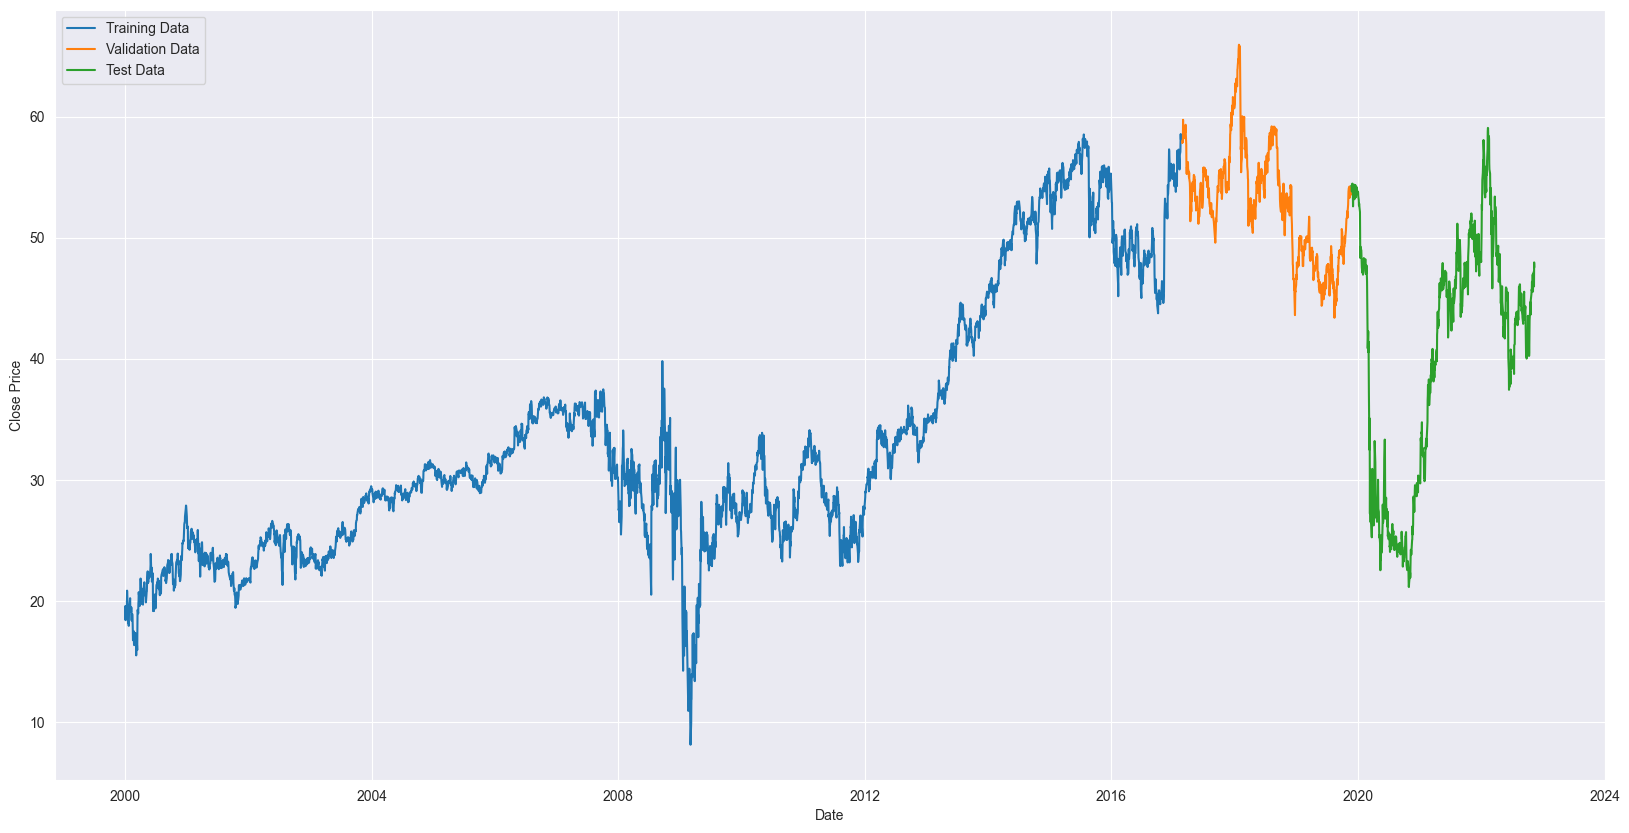

In [22]:
plotSeries(train_df.Date, train_df.Close, "Training Data")
plotSeries(valid_df.Date, valid_df.Close, "Validation Data")
plotSeries(test_df.Date, test_df.Close, "Test Data")
plt.legend(loc='upper left')

In [23]:
train_df.set_index(['Date'],inplace=True)
test_df.set_index(['Date'],inplace=True)
valid_df.set_index(['Date'],inplace=True)

In [25]:
scaler = MinMaxScaler()

trainNorm = scaler.fit_transform(train_df.values)
testNorm = scaler.transform(test_df.values)
validNorm = scaler.transform(valid_df.values)

trainNormDf = pd.DataFrame(trainNorm, columns=train_df.columns)
testNormDf = pd.DataFrame(testNorm, columns=test_df.columns)
validNormDf = pd.DataFrame(validNorm, columns=valid_df.columns)


In [26]:
trainNormDf.head(2)

,Close,Weekday,volumeChange,closeChange,EMA 10,EMA 20,EMA 50,EMA 100,ROC5,ROC10,ROC15,ROC20,DTB6,DGS5
0,0.23,0.00,0.27,0.33,0.19,0.16,0.09,0.04,0.48,0.47,0.47,0.47,0.84,0.99
1,0.21,0.25,0.07,0.40,0.18,0.15,0.08,0.03,0.48,0.47,0.47,0.47,0.84,0.99


In [27]:
def splitSequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [28]:
LOOK_BACK = 24
FORECAST_RANGE = 4
n_features = len(trainNormDf.columns)

In [29]:
#Add valid df
X_train, y_train = splitSequence(trainNormDf, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = splitSequence(testNormDf, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)

In [30]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(4286, 24, 14)
(4286, 4, 14)
(722, 24, 14)
(722, 4, 14)


In [31]:
def inverse_transform(y_test, yhat):
    y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
    yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
    yhat_inverse = scaler.inverse_transform(yhat_reshaped)
    y_test_inverse = scaler.inverse_transform(y_test_reshaped)
    return yhat_inverse, y_test_inverse

In [32]:
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)

In [33]:
mse_ = tf.keras.losses.MeanSquaredError()
mae_ = tf.keras.losses.MeanAbsoluteError()
mape_ = tf.keras.losses.MeanAbsolutePercentageError()
# mae = mae_(y_test_inverse,yhat_inverse)
# # print('mae:', mae)
# mse = mse_(y_test_inverse,yhat_inverse)
# # print('mse:', mse)
# mape = mape_(y_test_inverse,yhat_inverse)
# # print('mape:', mape)

In [34]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Encoder Decoder Model

In [35]:
tf.keras.backend.clear_session()
model_enc_dec = tf.keras.Sequential()

In [36]:
# WARNING:tensorflow:Layer lstm will not use cuDNN kernels since
# it doesn't meet the criteria. It will use a generic GPU kernel as fallback when running on GPU.
model_enc_dec.add(LSTM(100, input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')

In [37]:
# plot_model(model=model_enc_dec, show_shapes=True)

In [38]:
checkpoint_filepath = ''
# checkpoint_callback = ModelCheckpoint(
#  filepath=checkpoint_filepath,
#  save_weights_only=False,
#  monitor='val_loss',
#  mode='min',
#  save_best_only=True)
early_stopping_callback = EarlyStopping(
 monitor='val_loss',
 min_delta=0.005,
 patience=10,
 mode='min'
)
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0.001)

In [39]:
epochs = 50
batch_size = 32
validation = 0.1

In [40]:
history = model_enc_dec.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation, \
                            callbacks=[early_stopping_callback, rlrop_callback])

Epoch 1/50
121/121 [==============================] - 8s 28ms/step - loss: 0.0259 - val_loss: 0.0109 - lr: 0.0010
Epoch 2/50
121/121 [==============================] - 2s 21ms/step - loss: 0.0108 - val_loss: 0.0101 - lr: 0.0010
Epoch 3/50
121/121 [==============================] - 3s 23ms/step - loss: 0.0104 - val_loss: 0.0099 - lr: 0.0010
Epoch 4/50
121/121 [==============================] - 3s 23ms/step - loss: 0.0101 - val_loss: 0.0099 - lr: 0.0010
Epoch 5/50
121/121 [==============================] - 3s 23ms/step - loss: 0.0099 - val_loss: 0.0095 - lr: 0.0010
Epoch 6/50
121/121 [==============================] - 3s 22ms/step - loss: 0.0096 - val_loss: 0.0094 - lr: 0.0010
Epoch 7/50
121/121 [==============================] - 3s 22ms/step - loss: 0.0083 - val_loss: 0.0071 - lr: 0.0010
Epoch 8/50
121/121 [==============================] - 3s 23ms/step - loss: 0.0068 - val_loss: 0.0060 - lr: 0.0010
Epoch 9/50
121/121 [==============================] - 3s 21ms/step - loss: 0.0056 - val_

In [41]:
yhat = model_enc_dec.predict(X_test, verbose=0)

In [42]:
predData, testData = inverse_transform(y_test, yhat)
evaluate_forecast(testData, predData)

mae: tf.Tensor(65.97659, shape=(), dtype=float32)
mse: tf.Tensor(67042.56, shape=(), dtype=float32)
mape: tf.Tensor(1351440800.0, shape=(), dtype=float32)


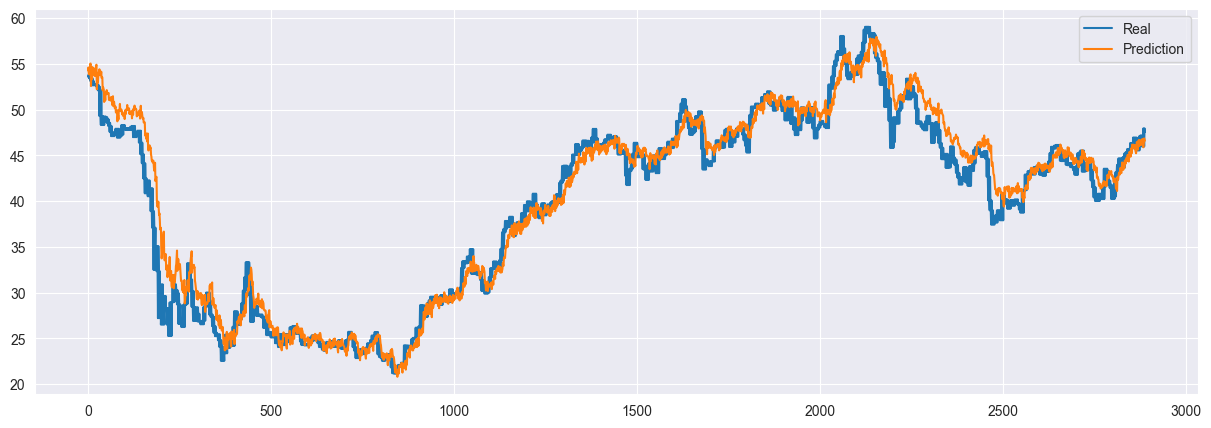

In [43]:
plotEvaluation(testData, predData, columns = testNormDf.columns)

## CNN-LSTM Encoder-Decoder Model

In [44]:
tf.keras.backend.clear_session()
model_enc_dec_cnn = Sequential()

In [45]:

model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())
model_enc_dec_cnn.add(RepeatVector(FORECAST_RANGE))
model_enc_dec_cnn.add(LSTM(200, return_sequences=True))
model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='relu')))
model_enc_dec_cnn.add(TimeDistributed(Dense(n_features)))
model_enc_dec_cnn.compile(loss='mse', optimizer='adam')

In [46]:
history = model_enc_dec_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation, \
                            callbacks=[early_stopping_callback, rlrop_callback])

Epoch 1/50
121/121 [==============================] - 4s 14ms/step - loss: 0.0214 - val_loss: 0.0103 - lr: 0.0010
Epoch 2/50
121/121 [==============================] - 1s 9ms/step - loss: 0.0091 - val_loss: 0.0075 - lr: 0.0010
Epoch 3/50
121/121 [==============================] - 1s 10ms/step - loss: 0.0070 - val_loss: 0.0057 - lr: 0.0010
Epoch 4/50
121/121 [==============================] - 1s 10ms/step - loss: 0.0058 - val_loss: 0.0053 - lr: 0.0010
Epoch 5/50
121/121 [==============================] - 1s 10ms/step - loss: 0.0050 - val_loss: 0.0045 - lr: 0.0010
Epoch 6/50
121/121 [==============================] - 1s 10ms/step - loss: 0.0046 - val_loss: 0.0045 - lr: 0.0010
Epoch 7/50
121/121 [==============================] - 1s 10ms/step - loss: 0.0044 - val_loss: 0.0037 - lr: 0.0010
Epoch 8/50
121/121 [==============================] - 1s 9ms/step - loss: 0.0041 - val_loss: 0.0040 - lr: 0.0010
Epoch 9/50
121/121 [==============================] - 1s 9ms/step - loss: 0.0038 - val_los

In [47]:
yhat = model_enc_dec_cnn.predict(X_test, verbose=0)

In [48]:
predData, testData = inverse_transform(y_test, yhat)
evaluate_forecast(testData, predData)

mae: tf.Tensor(101.446175, shape=(), dtype=float32)
mse: tf.Tensor(127198.734, shape=(), dtype=float32)
mape: tf.Tensor(1473062500.0, shape=(), dtype=float32)


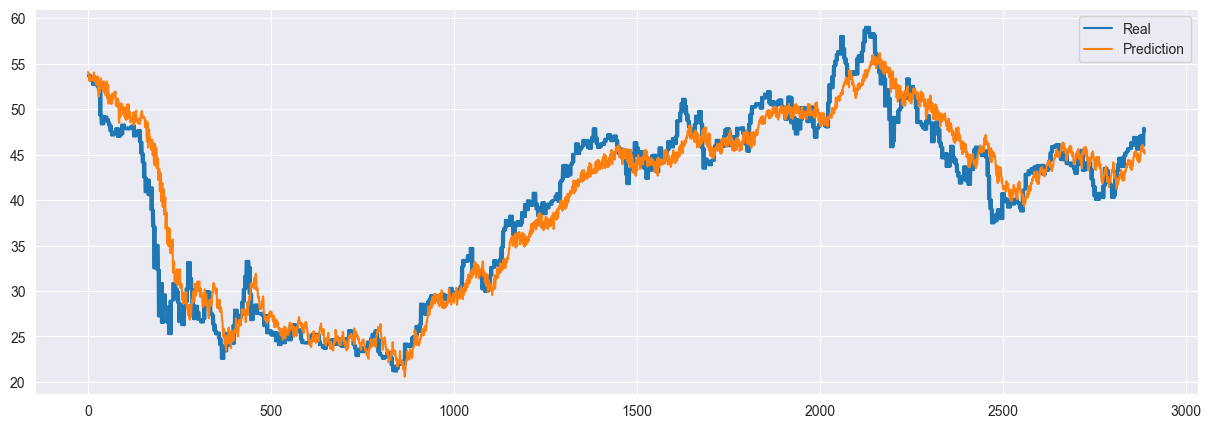

In [49]:
plotEvaluation(testData, predData, columns = testNormDf.columns)

## Model Vector Output

In [50]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
conv = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
conv = Conv1D(filters=6, kernel_size=11, activation='relu')(conv)
lstm = LSTM(100, return_sequences=True)(conv)
dropout = Dropout(0.2)(lstm)
lstm = LSTM(100)(dropout)
dense = Dense(FORECAST_RANGE*n_features, activation='relu')(lstm)
output_layer = Reshape((FORECAST_RANGE,n_features))(dense)
model_vector_output = Model([input_layer], [output_layer])
model_vector_output.compile(optimizer='adam', loss='mse')

In [51]:
history = model_vector_output.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation, \
                            callbacks=[early_stopping_callback, rlrop_callback])

Epoch 1/50
121/121 [==============================] - 6s 18ms/step - loss: 0.0490 - val_loss: 0.0249 - lr: 0.0010
Epoch 2/50
121/121 [==============================] - 1s 11ms/step - loss: 0.0274 - val_loss: 0.0236 - lr: 0.0010
Epoch 3/50
121/121 [==============================] - 1s 11ms/step - loss: 0.0259 - val_loss: 0.0236 - lr: 0.0010
Epoch 4/50
121/121 [==============================] - 1s 11ms/step - loss: 0.0253 - val_loss: 0.0222 - lr: 0.0010
Epoch 5/50
121/121 [==============================] - 1s 11ms/step - loss: 0.0237 - val_loss: 0.0207 - lr: 0.0010
Epoch 6/50
121/121 [==============================] - 1s 11ms/step - loss: 0.0187 - val_loss: 0.0169 - lr: 0.0010
Epoch 7/50
121/121 [==============================] - 1s 11ms/step - loss: 0.0171 - val_loss: 0.0160 - lr: 0.0010
Epoch 8/50
121/121 [==============================] - 1s 11ms/step - loss: 0.0165 - val_loss: 0.0148 - lr: 0.0010
Epoch 9/50
121/121 [==============================] - 1s 11ms/step - loss: 0.0156 - val_

In [52]:
yhat = model_vector_output.predict(X_test, verbose=0)

In [53]:
predData, testData = inverse_transform(y_test, yhat)
evaluate_forecast(testData, predData)

mae: tf.Tensor(70.73833, shape=(), dtype=float32)
mse: tf.Tensor(118319.414, shape=(), dtype=float32)
mape: tf.Tensor(695860100.0, shape=(), dtype=float32)


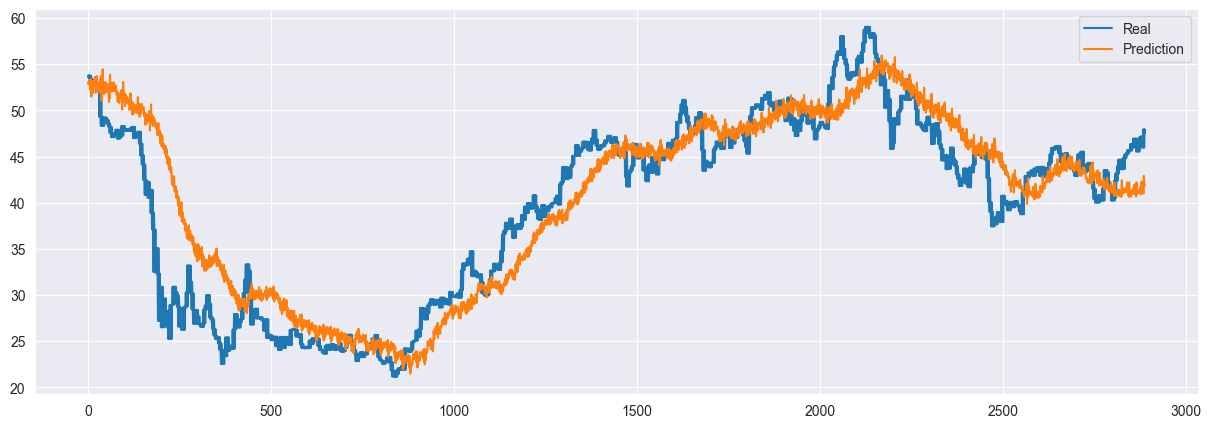

In [54]:
plotEvaluation(testData, predData, columns = testNormDf.columns)

## Multihead CNN LSTM Model

In [55]:
input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
for i in range(0, n_features):
    conv_layer_head = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
    conv_layer_head_2 = Conv1D(filters=6, kernel_size=11, activation='relu')(conv_layer_head)
    conv_layer_flatten = Flatten()(conv_layer_head_2)
    head_list.append(conv_layer_flatten)

concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100)(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation='linear')(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)
multi_head_cnn_lstm_model.compile(optimizer='adam', loss='mse')

In [56]:
history = multi_head_cnn_lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation, \
                            callbacks=[early_stopping_callback, rlrop_callback])

Epoch 1/50
121/121 [==============================] - 10s 38ms/step - loss: 0.0371 - val_loss: 0.0127 - lr: 0.0010
Epoch 2/50
121/121 [==============================] - 4s 30ms/step - loss: 0.0150 - val_loss: 0.0104 - lr: 0.0010
Epoch 3/50
121/121 [==============================] - 4s 30ms/step - loss: 0.0135 - val_loss: 0.0112 - lr: 0.0010
Epoch 4/50
121/121 [==============================] - 4s 30ms/step - loss: 0.0126 - val_loss: 0.0101 - lr: 0.0010
Epoch 5/50
121/121 [==============================] - 4s 30ms/step - loss: 0.0119 - val_loss: 0.0095 - lr: 0.0010
Epoch 6/50
121/121 [==============================] - 4s 30ms/step - loss: 0.0109 - val_loss: 0.0081 - lr: 0.0010
Epoch 7/50
121/121 [==============================] - 4s 29ms/step - loss: 0.0097 - val_loss: 0.0075 - lr: 0.0010
Epoch 8/50
121/121 [==============================] - 3s 29ms/step - loss: 0.0088 - val_loss: 0.0066 - lr: 0.0010
Epoch 9/50
121/121 [==============================] - 3s 29ms/step - loss: 0.0080 - val

In [57]:
yhat = multi_head_cnn_lstm_model.predict(X_test, verbose=0)

In [58]:
predData, testData = inverse_transform(y_test, yhat)
evaluate_forecast(testData, predData)

mae: tf.Tensor(112.73169, shape=(), dtype=float32)
mse: tf.Tensor(189503.38, shape=(), dtype=float32)
mape: tf.Tensor(975701950.0, shape=(), dtype=float32)


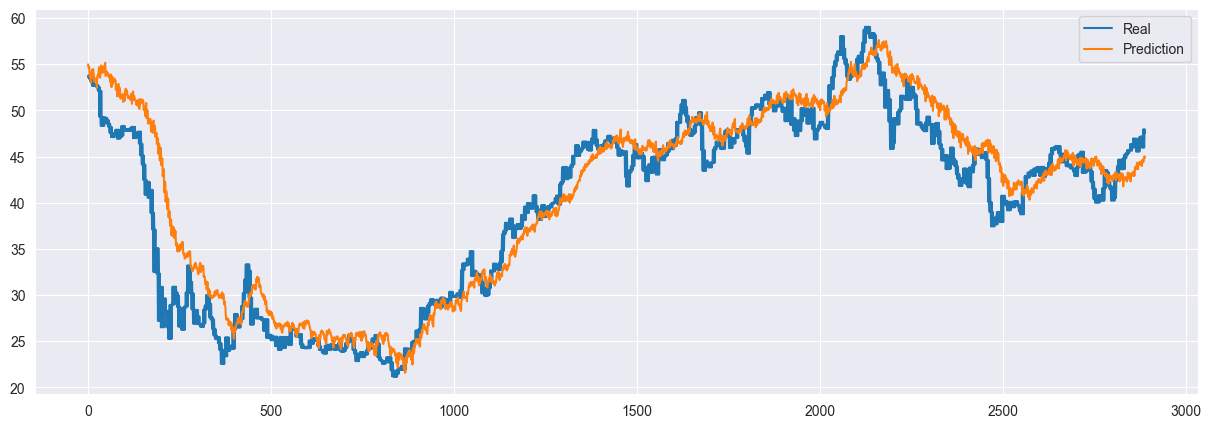

In [59]:
plotEvaluation(testData, predData, columns = testNormDf.columns)

## Ploting The Evaluation

Text(0, 0.5, 'MAPE')

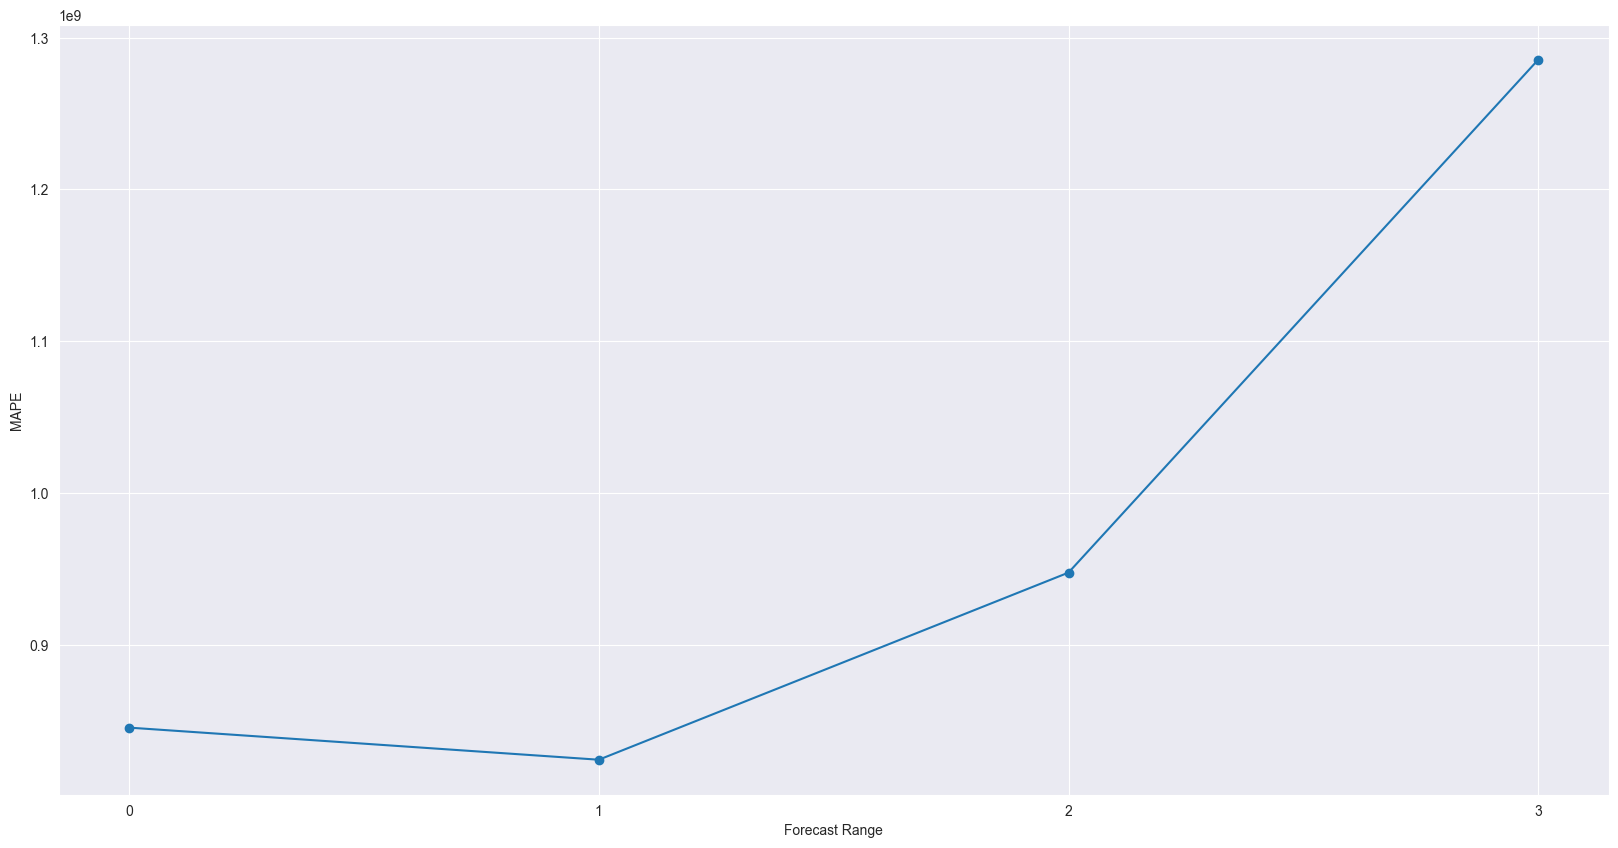

In [60]:
y_test_inverse_time_step  = testData.reshape(int(testData.shape[0]/FORECAST_RANGE), \
                                                  FORECAST_RANGE, testData.shape[-1])
yhat_inverse_time_step = predData.reshape(int(predData.shape[0]/FORECAST_RANGE), \
                                              FORECAST_RANGE, predData.shape[-1])
# yhat_inverse_time_step and y_test_inverse_time_step are both same dimension.
time_step_list_yhat = [[] for i in range(FORECAST_RANGE)]
time_step_list_y_test = [[] for i in range(FORECAST_RANGE)]
for i in range(0, yhat_inverse_time_step.shape[0]):
    for j in range(0, yhat_inverse_time_step.shape[1]):
        time_step_list_yhat[j].append(list(yhat_inverse_time_step[i][j]))
        time_step_list_y_test[j].append(list(y_test_inverse_time_step[i][j]))
yhat_time_step = np.array(time_step_list_yhat)
yhat_time_step = yhat_time_step.reshape(yhat_time_step.shape[0], -1)
y_test_time_step = np.array(time_step_list_y_test)
y_test_time_step = y_test_time_step.reshape(y_test_time_step.shape[0], -1)
# plotting
mape_list = []
for i in range(0, FORECAST_RANGE):
    mape = mape_(y_test_time_step[i], yhat_time_step[i])
    mape_list.append(mape)
plt.plot(range(0, FORECAST_RANGE), mape_list, marker='o')
plt.xticks((range(0, FORECAST_RANGE)))
plt.xlabel('Forecast Range')
plt.ylabel('MAPE')

In [61]:
for i in range(0, n_features):
    print('->', i)
    mae = mae_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mae:', mae)
    mse = mse_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mse:', mse)
    mape = mape_(y_test_inverse[:,i],yhat_inverse[:,i])
    print('mape:', mape)

-> 0


NameError: name 'y_test_inverse' is not defined